### ДЗ Анализ временных рядов

In [18]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings("ignore") 

In [19]:
sales_of_company_x = pd.read_csv("data/TimeSeries/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("data/TimeSeries/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("data/TimeSeries/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("data/TimeSeries/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("data/TimeSeries/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("data/TimeSeries/daily-total-female-births-in-cal.csv")
monthly_car_sales_in_quebec_1960 = pd.read_csv("data/TimeSeries/monthly-car-sales-in-quebec-1960.csv")

In [20]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"],
    "Monthly car sales in Quebec 1960": monthly_car_sales_in_quebec_1960["Count"]
}

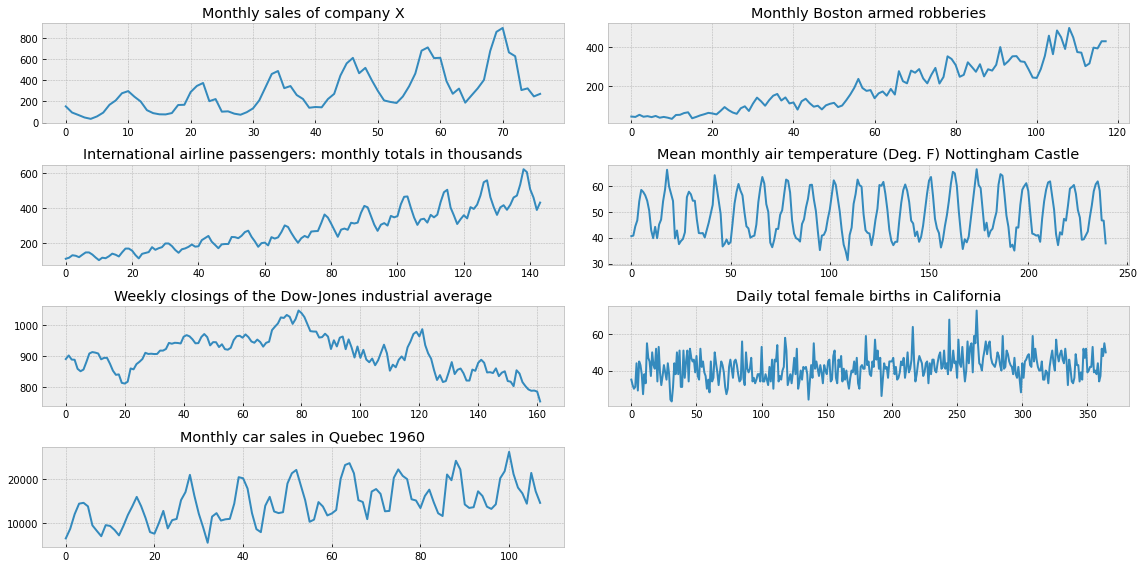

In [21]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (np.ceil(len(all_series)/2).astype(int), 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax)
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [22]:
def tsplot(y, lags=None, figsize=(12, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Итоговое представление ряда')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [23]:
def difference(dataset, lag):
    diff = list()
    for i in range(lag, len(dataset)):
        value = dataset[i] - dataset[i - lag]
        diff.append(value)
    return diff

In [24]:
def test_stationarity_short(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')

    if dftest[0]> dftest[4]['5%']: 
        print ('{:0.2f} >  {:0.2f} есть единичные корни, ряд не стационарен'.format(dftest[0],dftest[4]['5%']))
    else:
        print ('{:0.2f} <  {:0.2f} единичных корней нет, ряд стационарен'.format(dftest[0],dftest[4]['5%']))


In [25]:
def test_stationarity(timeseries):
    print('Results of Jarque-Bera Test:')
    row =  ['JB', 'p-value', 'skew', 'kurtosis']
    jb_test = sm.stats.stattools.jarque_bera(timeseries)
    a = np.vstack([jb_test])
    itog = SimpleTable(a, row)
    print (itog)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
  
    row =  ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    a = np.vstack([dftest])
    itog = SimpleTable(a, row)
    print (itog)
    
    #dfoutput = pd.Series()
    #for [key, value] in dftest[4].items():
    #    dfoutput['Critical Value (%s)' % key] = value
    #print(dfoutput)
    
    print ('Critical values: ', dftest[4])
    if dftest[0]> dftest[4]['5%']: 
        print ('\n {:0.2f} >  {:0.2f} есть единичные корни, ряд не стационарен'.format(dftest[0],dftest[4]['5%']))
    else:
        print ('\n {:0.2f} <  {:0.2f} единичных корней нет, ряд стационарен'.format(dftest[0],dftest[4]['5%']))


Считаем коэф. вариации и проводим тест Харки — Бера для определения номарльности распределения, чтобы подтвердить предположение об однородности ряда.

Отдельно для каждого ряда  убираем сезонность, тренд, нормализуем дисперсию и проверяем на стационарность. Возможно одного шага достаточно для получения стационарного ряда. 

А также смотри итоговую статистику для последовательно выполненных шагов - нормализовали дисперсию, исключили сезонность, продифференцировали.

Проводим тест Дики-Фуллера и графики коррелограмм, чтобы отвергунть гипотезу о нестационарности ряда.

In [26]:
def series_analyze(series,lag = 12 ):
    print('Исходный ряд:')
    test_stationarity(series)
    series_desc = series.describe()


    print ('коэф. вариации  = %f' % (series_desc['std']/series_desc['mean']))


    series_season = difference(series,lag) # убираем сезонность
    series_diff = np.diff(series, 1)   # дифференцирование 1 порядка убираем тренд
    series_diff2 = np.diff(series, 2)    # дифференцирование 2 порядка
    series_boxcox = boxcox(series, 0) # нормализуем дисперсию

    series_rezult = np.diff( difference(boxcox(series, 0),lag), 1)  # последовательное разложение ряда


    print('Исключена сезонность:')
    test_stationarity_short(series_season)
    print('Нормализована дисперсия:')
    test_stationarity_short(series_boxcox)
    print('Дифференцирование 1 порядка:')
    test_stationarity_short(series_diff)
    print('Дифференцирование 2 порядка:')
    test_stationarity_short(series_diff2)

    with plt.style.context('bmh'):
        fig, axs = plt.subplots(5, 1, tight_layout=True, figsize=(8,8))

        axs[0].plot(series,     color='#86bf95' )
        axs[0].set_title('Исходный ряд')
        axs[1].plot(series_season,   color='#86bf95')
        axs[1].set_title('Исключена сезонность')
        axs[2].plot(series_boxcox,   color='#86bf95')
        axs[2].set_title('Нормализация Бокса-Кокса')
        axs[3].plot(series_diff,   color='#86bf95')
        axs[3].set_title('Дифференцирование 1-го порядка')
        axs[4].plot(series_diff2,   color='#86bf95')
        axs[4].set_title('Дифференцирование 2-го порядка')

        fig.show()

    tsplot(series_rezult)

    print('\n Последовательное разложение ряда:')

    test_stationarity(series_rezult)

## Monthly sales of company X

Исходный ряд:
Results of Jarque-Bera Test:
        JB                p-value               skew             kurtosis     
------------------------------------------------------------------------------
14.164796378099561 0.0008397568359472747 1.0212393036962546 3.4932368668728246
------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
  Test Statistic        p-value       #Lags Used Number of Observations Used
----------------------------------------------------------------------------
0.6547150829524457 0.9888894205170052         12                          64
----------------------------------------------------------------------------
Critical values:  {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}

 0.65 >  -2.91 есть единичные корни, ряд не стационарен
коэф. вариации  = 0.664976
Исключена сезонность:
-2.02 >  -2.92 есть единичные корни, ряд не стационарен
Нормализована дисперсия:
-0.91 >  -2.91 ест

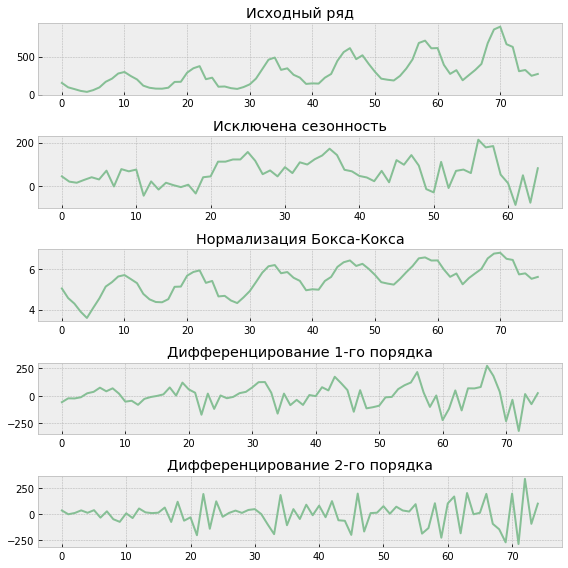

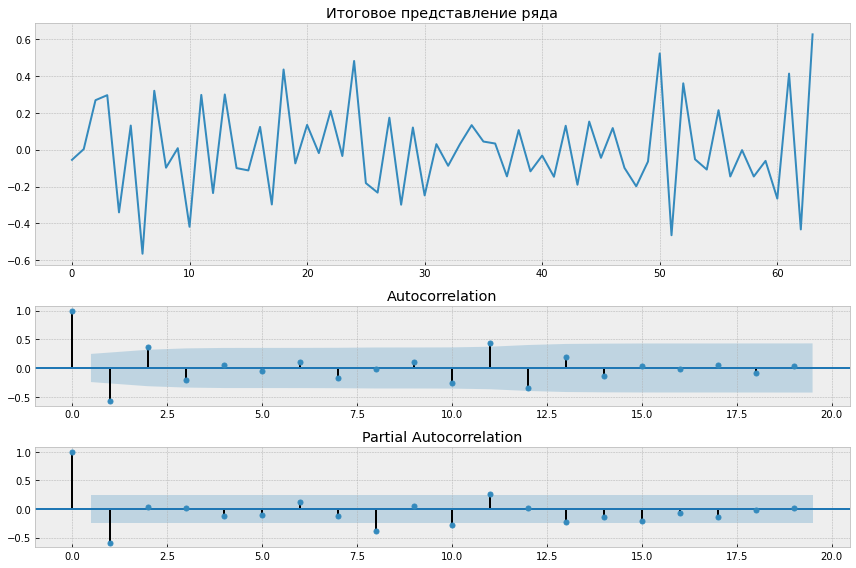

In [27]:
series_analyze(all_series["Monthly sales of company X"],12)

## Monthly Boston armed robberies

Исходный ряд:
Results of Jarque-Bera Test:
        JB              p-value               skew             kurtosis    
---------------------------------------------------------------------------
8.380977651157563 0.015138882790888463 0.4657071702508834 2.085083091055855
---------------------------------------------------------------------------
Results of Dickey-Fuller Test:
  Test Statistic        p-value      #Lags Used Number of Observations Used
---------------------------------------------------------------------------
1.0011021402457776 0.994277563805723         11                         106
---------------------------------------------------------------------------
Critical values:  {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}

 1.00 >  -2.89 есть единичные корни, ряд не стационарен
коэф. вариации  = 0.652325
Исключена сезонность:
-2.29 >  -2.89 есть единичные корни, ряд не стационарен
Нормализована дисперсия:
-2.01 >  -2.89 есть единичные ко

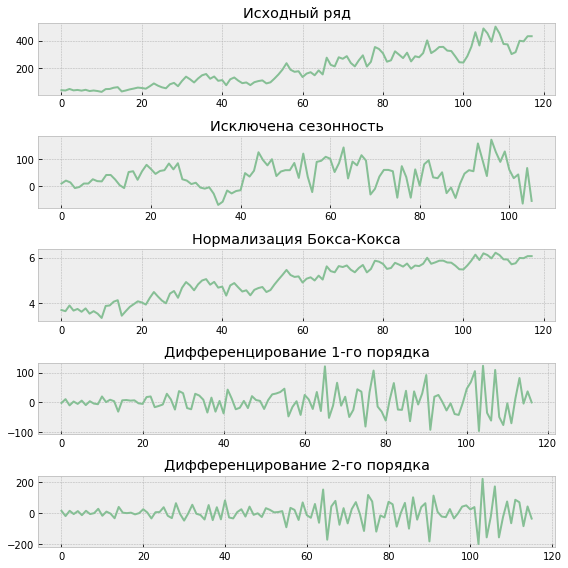

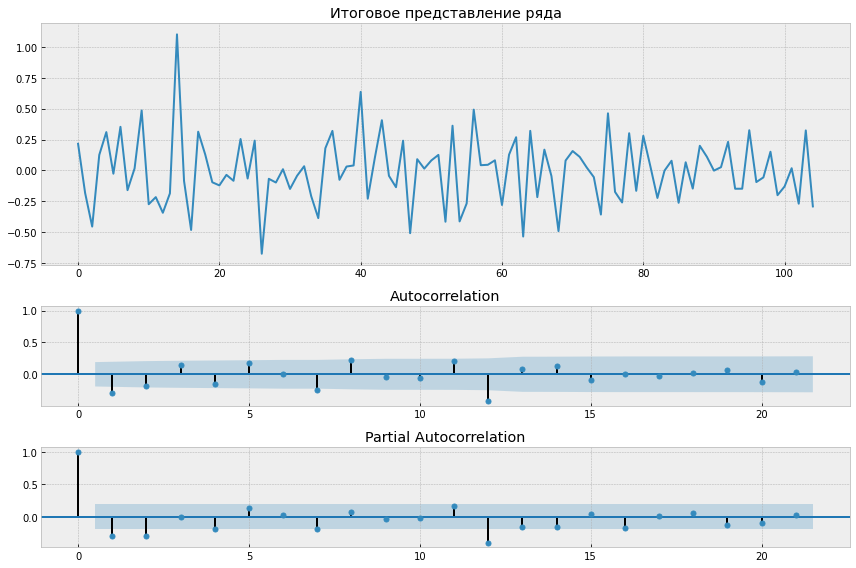

In [28]:
series_analyze(all_series["Monthly Boston armed robberies"])

## International airline passengers: monthly totals in thousands

Исходный ряд:
Results of Jarque-Bera Test:
        JB              p-value               skew            kurtosis     
---------------------------------------------------------------------------
8.922525081089006 0.011547774546404262 0.577068234901525 2.6062278290871896
---------------------------------------------------------------------------
Results of Dickey-Fuller Test:
  Test Statistic        p-value       #Lags Used Number of Observations Used
----------------------------------------------------------------------------
0.8153688792060433 0.9918802434376409         13                         130
----------------------------------------------------------------------------
Critical values:  {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}

 0.82 >  -2.88 есть единичные корни, ряд не стационарен
коэф. вариации  = 0.427995
Исключена сезонность:
-3.38 <  -2.88 единичных корней нет, ряд стационарен
Нормализована дисперсия:
-1.72 >  -2.88 есть единичные 

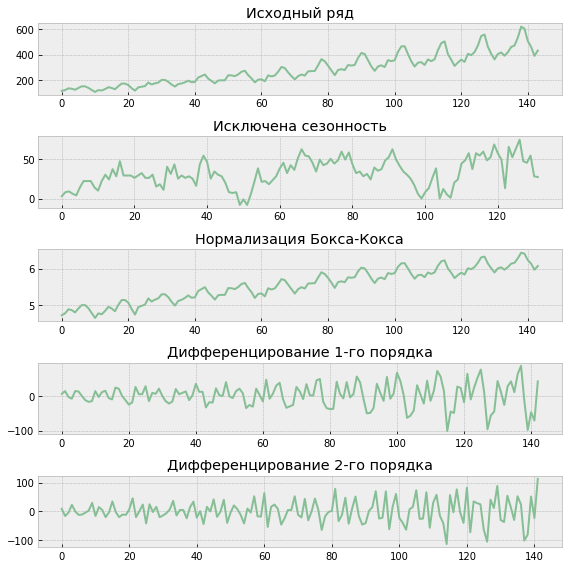

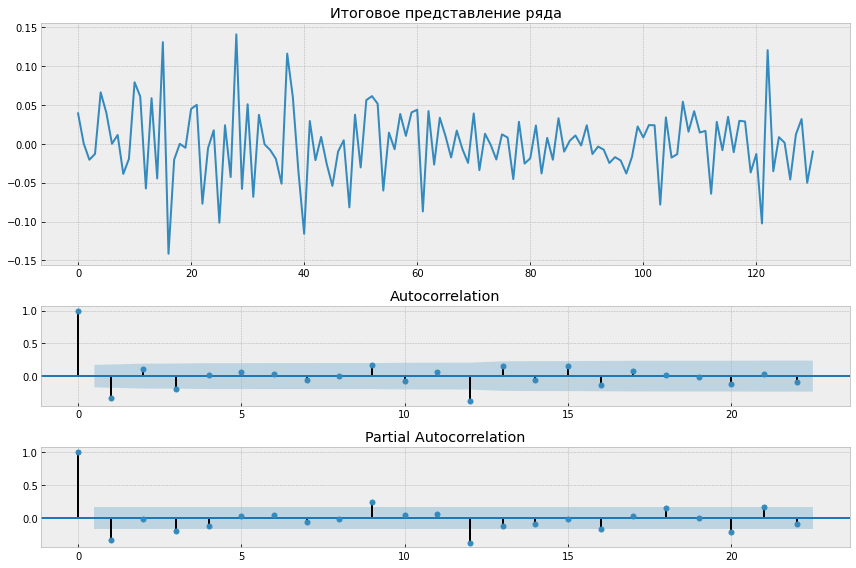

In [29]:
series_analyze(all_series["International airline passengers: monthly totals in thousands"])

## Mean monthly air temperature (Deg. F) Nottingham Castle

Исходный ряд:
Results of Jarque-Bera Test:
        JB                p-value               skew             kurtosis     
------------------------------------------------------------------------------
16.423715017106893 0.0002714160950427594 0.1819617366303889 1.7712074189186764
------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
   Test Statistic         p-value        #Lags Used Number of Observations Used
-------------------------------------------------------------------------------
-3.2554924030863335 0.016989030222608788         14                         225
-------------------------------------------------------------------------------
Critical values:  {'1%': -3.4597521044060353, '5%': -2.874472927517147, '10%': -2.5736628197530864}

 -3.26 <  -2.87 единичных корней нет, ряд стационарен
коэф. вариации  = 0.174745
Исключена сезонность:
-6.07 <  -2.88 единичных корней нет, ряд стационарен
Нормализована дисперсия:
-3.76 < 

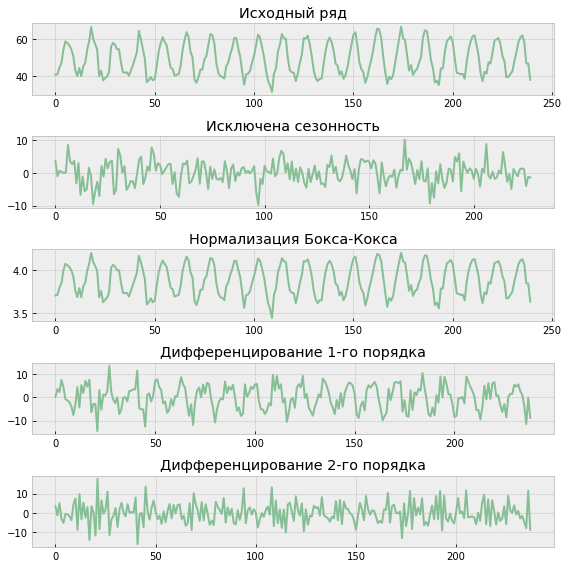

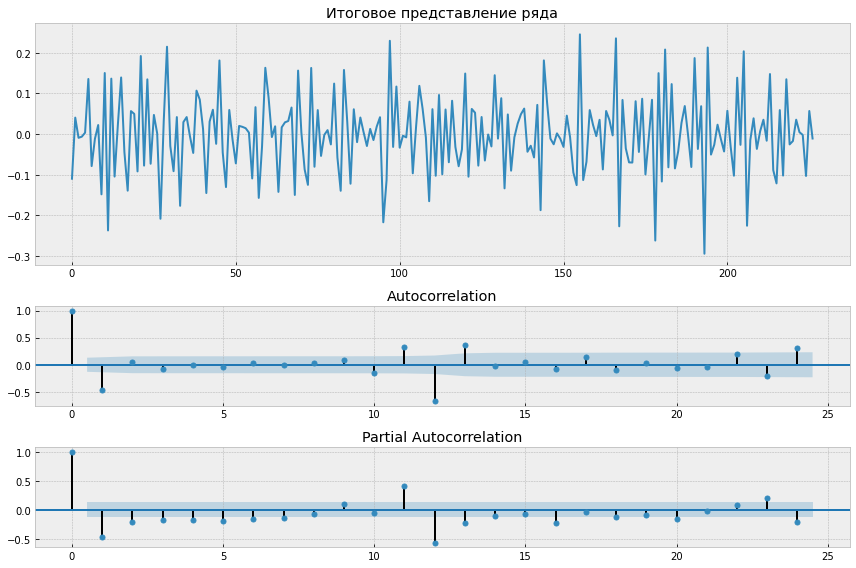

In [30]:
series_analyze(all_series["Mean monthly air temperature (Deg. F) Nottingham Castle"])

## Weekly closings of the Dow-Jones industrial average

Исходный ряд:
Results of Jarque-Bera Test:
        JB             p-value                skew              kurtosis    
----------------------------------------------------------------------------
1.815315644916955 0.4034681121763931 -0.032927955468866385 2.485608466153097
----------------------------------------------------------------------------
Results of Dickey-Fuller Test:
   Test Statistic        p-value       #Lags Used Number of Observations Used
-----------------------------------------------------------------------------
-1.3146254984911718 0.6224548515589717          0                         161
-----------------------------------------------------------------------------
Critical values:  {'1%': -3.471633386932248, '5%': -2.8796651107461972, '10%': -2.576433647235832}

 -1.31 >  -2.88 есть единичные корни, ряд не стационарен
коэф. вариации  = 0.066778
Исключена сезонность:
-3.70 <  -2.88 единичных корней нет, ряд стационарен
Нормализована дисперсия:
-1.21 >  -2.88 есть ед

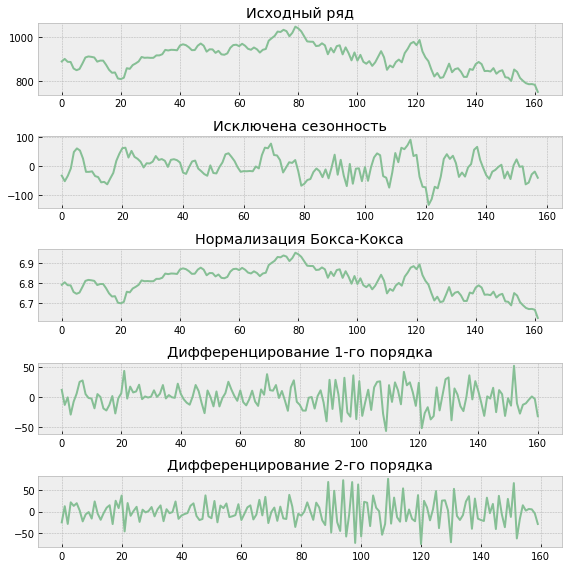

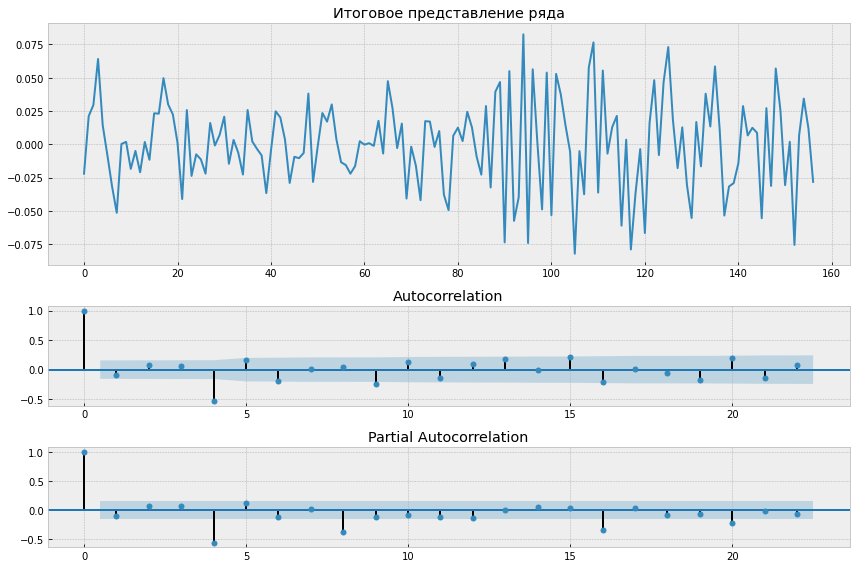

In [31]:
series_analyze(all_series["Weekly closings of the Dow-Jones industrial average"],4)

## Daily total female births in California

Исходный ряд:
Results of Jarque-Bera Test:
        JB                p-value                 skew             kurtosis     
--------------------------------------------------------------------------------
20.642802203515053 3.2920957340618004e-05 0.44554790047635295 3.7505219603273874
--------------------------------------------------------------------------------
Results of Dickey-Fuller Test:
  Test Statistic          p-value        #Lags Used Number of Observations Used
-------------------------------------------------------------------------------
-4.808291253559763 5.243412990149865e-05          6                         358
-------------------------------------------------------------------------------
Critical values:  {'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}

 -4.81 <  -2.87 единичных корней нет, ряд стационарен
коэф. вариации  = 0.175038
Исключена сезонность:
-12.63 <  -2.87 единичных корней нет, ряд стационарен
Нормализована дисперсия:

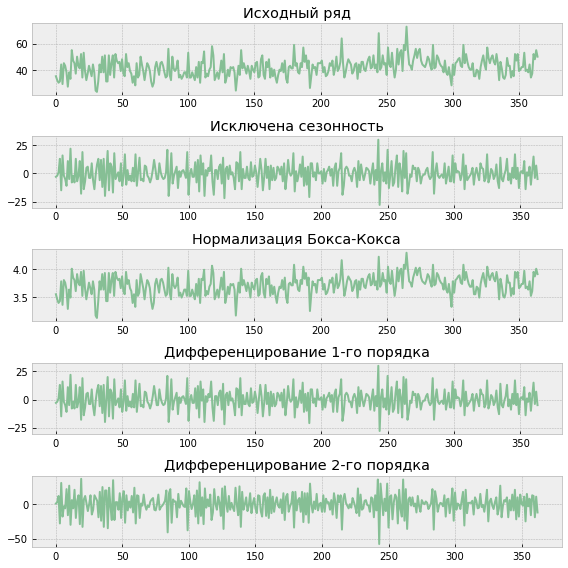

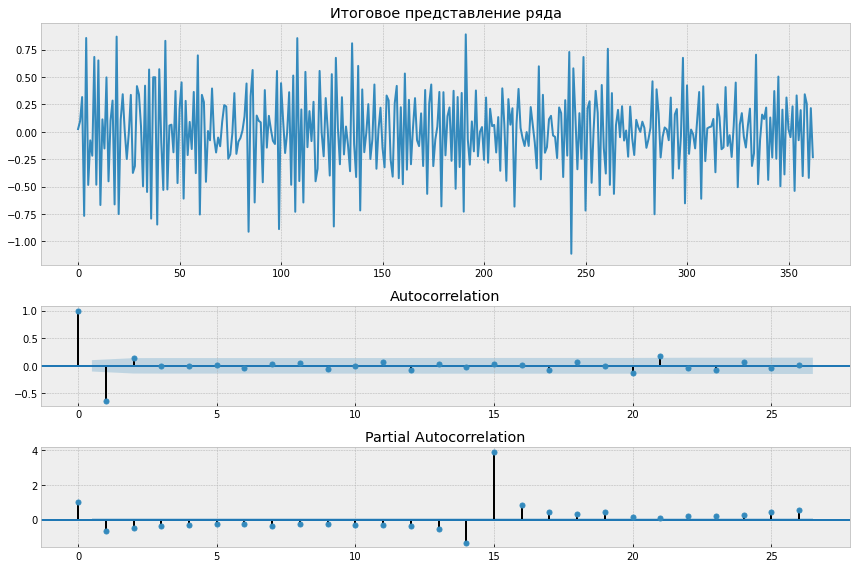

In [32]:
series_analyze(all_series["Daily total female births in California"],1)

## Monthly car sales in Quebec 1960

Исходный ряд:
Results of Jarque-Bera Test:
        JB               p-value               skew             kurtosis    
----------------------------------------------------------------------------
3.4945201159396397 0.17425072686303192 0.31500339419302226 2.383841357804773
----------------------------------------------------------------------------
Results of Dickey-Fuller Test:
   Test Statistic        p-value       #Lags Used Number of Observations Used
-----------------------------------------------------------------------------
-1.2238127661752847 0.6632691049832866         12                          95
-----------------------------------------------------------------------------
Critical values:  {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}

 -1.22 >  -2.89 есть единичные корни, ряд не стационарен
коэф. вариации  = 0.310050
Исключена сезонность:
-3.64 <  -2.90 единичных корней нет, ряд стационарен
Нормализована дисперсия:
-1.45 >  -2.89 есть 

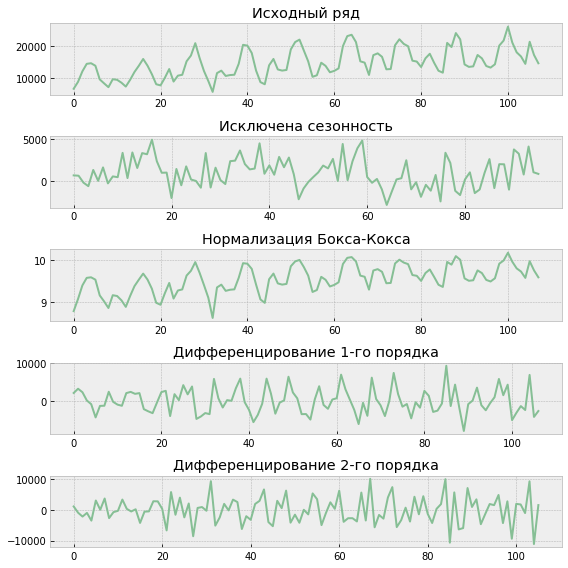

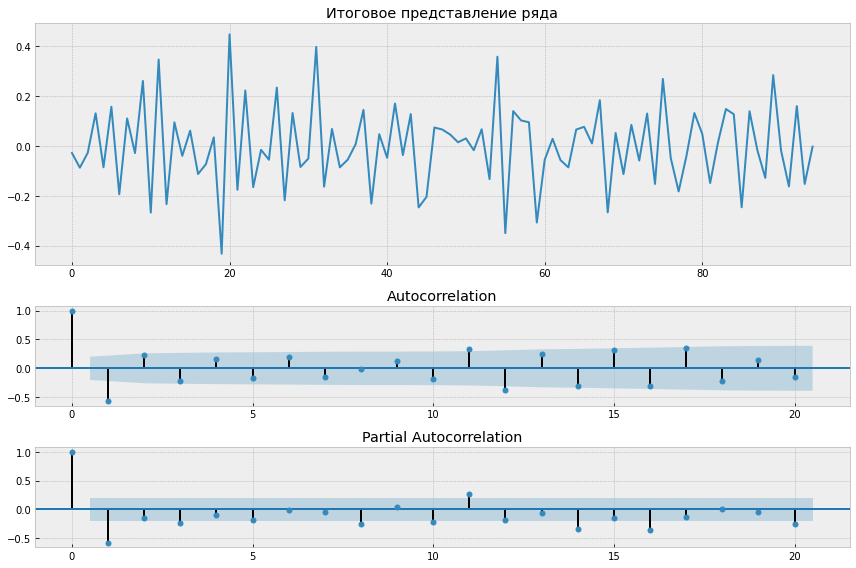

In [33]:
series_analyze(all_series["Monthly car sales in Quebec 1960"])